In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
TRAIN_2019_QA_PAIRS = "/mnt/workspace/imageclef/2019-Dataset/2019-QAPairsByCategory/C4_Abnormality_train.txt"
TRAIN_2019_IMAGES = "/mnt/workspace/imageclef/2019-Dataset/2019-Train-Images/"

DATASET_COMMON_FOLDER = "/mnt/workspace/imageclef/2020-2021-Datasets/VQA/"

TRAIN_2020_IMAGES = DATASET_COMMON_FOLDER + "VQAMed2020-VQAnswering-TrainingSet/" \
                                              "VQAnswering_2020_Train_images/"
TRAIN_2020_QA_PAIRS = DATASET_COMMON_FOLDER + "VQAMed2020-VQAnswering-TrainingSet/" \
                                              "VQAnswering_2020_Train_QA_pairs.txt"
VAL_2020_IMAGES = DATASET_COMMON_FOLDER + "VQAMed2020-VQAnswering-ValidationSet/" \
                                          "VQAnswering_2020_Val_images/"
VAL_2020_QA_PAIRS = DATASET_COMMON_FOLDER + "VQAMed2020-VQAnswering-ValidationSet/" \
                                            "VQAnswering_2020_Val_QA_Pairs.txt"
VAL_2021_IMAGES = DATASET_COMMON_FOLDER + "VQA-Med-2021-Tasks-1-2-NewValidationSets/" \
                                          "ImageCLEF-2021-VQA-Med-New-Validation-Images/"
VAL_2021_QA_PAIRS = DATASET_COMMON_FOLDER + "VQA-Med-2021-Tasks-1-2-NewValidationSets/" \
                                            "VQA-Med-2021-VQAnswering-Task1-New-ValidationSet.txt"
TEST_2021_IMAGES = DATASET_COMMON_FOLDER + "VQA-500-Images/"
TEST_2021_QUESTIONS = DATASET_COMMON_FOLDER + "Task1-VQA-2021-TestSet-Questions.txt"
TEST_2021_ANSWERS = DATASET_COMMON_FOLDER + "Task1-VQA-2021-TestSet-ReferenceAnswers.txt"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import PIL
from PIL import Image
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
import torchvision.transforms as transforms
import torchvision.models as models
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm
import math
import copy
import time
import pandas as pd
import re
import os
import pickle

In [4]:
with open('./id2imagefolder.pickle', 'rb') as f:
    id2imagefolder = pickle.load(f)

In [5]:
with open('./id2imagetype.pickle', 'rb') as f:
    id2imagetype = pickle.load(f)

In [6]:
with open('./id2labels.pickle', 'rb') as f:
    id2labels = pickle.load(f)

In [7]:
with open('./id2answer.pickle', 'rb') as f:
    id2answer = pickle.load(f)

In [8]:
with open('./id2question.pickle', 'rb') as f:
    id2question = pickle.load(f)

In [9]:
with open('./imagetype2name.pickle', 'rb') as f:
    imagetype2name = pickle.load(f)

In [10]:
with open('./labels.pickle', 'rb') as f:
    labels = pickle.load(f)

In [11]:
N_TYPE_CLASSES = max(id2imagetype.values())+1
N_MULTILABEL_CLASSES = len(labels)
N_TYPE_CLASSES, N_MULTILABEL_CLASSES

(9, 618)

In [12]:
def get_labels(array):
    assert len(array) == len(labels)
    return [w for i, w in enumerate(labels) if array[i] == 2]

In [13]:
class Tokenizer:
    PAD_TOKEN = '<pad>'
    START_TOKEN = '<s>'
    END_TOKEN = '</s>'
    
    def __init__(self):
        self._build_token2id()
        
    def _build_token2id(self):
        vocab = set()
        for q in id2question.values():
            vocab.update(q.split())
        for a in id2answer.values():
            vocab.update(a.split())
        vocab = list(vocab)
        vocab.sort()       
        self.id2token = [self.PAD_TOKEN, self.START_TOKEN, self.END_TOKEN]        
        self.id2token.extend(vocab)
        self.token2id = {t:i for i,t in enumerate(self.id2token)}
        self.vocab_size = len(self.id2token)

    def string2ids(self, s):
        ids = [self.token2id[self.START_TOKEN]]
        ids.extend(self.token2id[x] for x in s.split())
        ids.append(self.token2id[self.END_TOKEN])
        return ids

    def ids2sentence(self, ids):
        return ' '.join(self.id2token[i] for i in ids)

    def clean_sentence(self, sentence):
        clean = []
        for token in sentence:
            if token == self.token2id[self.END_TOKEN]:
                break
            if token >= 3:
                clean.append(token)
        return clean

class VQADataset(Dataset):
    
    def __init__(self, ids, id2imagefolder, id2question, id2answer, id2imagetype, id2labels, tokenizer, ignore_gt_ids=None):
        self.ids = ids
        self.images = []
        self.questions = []
        self.answers = []
        self.types = []
        self.labels = []
        for _id in ids:
            self.images.append(os.path.join(id2imagefolder[_id], _id + '.jpg'))
            self.questions.append(tokenizer.string2ids(id2question[_id]))            
            self.types.append(id2imagetype[_id])
            self.labels.append(id2labels[_id])
            if ignore_gt_ids and _id in ignore_gt_ids:
                self.answers.append([0])
                # self.labels.append([0 for _ in range(N_MULTILABEL_CLASSES)])
            else:
                self.answers.append(tokenizer.string2ids(id2answer[_id]))
                # self.labels.append(id2labels[_id])
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):    
        return dict(
            idx=i,
            i=self.transform(Image.open(self.images[i]).convert('RGB')),
            q=self.questions[i],
            a=self.answers[i],
            t=self.types[i],
            ml=self.labels[i],
        )

In [14]:
def collate_batch(batch):
    indexes = sorted(range(len(batch)), key=lambda i : len(batch[i]['q']), reverse=True)
    batch_dict = dict()
    batch_dict['idx'] = torch.tensor([batch[i]['idx'] for i in indexes])
    batch_dict['i'] = torch.stack([batch[i]['i'] for i in indexes])
    batch_dict['q'] = nn.utils.rnn.pad_sequence(
        sequences = [torch.tensor(batch[i]['q']) for i in indexes],
        batch_first=True,
        padding_value=0,
    )
    batch_dict['ql'] = torch.tensor([len(batch[i]['q']) for i in indexes])
    batch_dict['a'] = nn.utils.rnn.pad_sequence(
        sequences = [torch.tensor(batch[i]['a']) for i in indexes],
        batch_first=True,
        padding_value=0,
    )
    batch_dict['t'] = torch.tensor([batch[i]['t'] for i in indexes])
    batch_dict['ml'] = torch.tensor([batch[i]['ml'] for i in indexes])
    return batch_dict

# def collate_test_batch(batch):
#     indexes = sorted(range(len(batch)), key=lambda i : len(batch[i]['q']), reverse=True)
#     batch_dict = dict()
#     batch_dict['idx'] = torch.tensor([batch[i]['idx'] for i in indexes])
#     batch_dict['i'] = torch.stack([batch[i]['i'] for i in indexes])
#     batch_dict['q'] = nn.utils.rnn.pad_sequence(
#         sequences = [torch.tensor(batch[i]['q']) for i in indexes],
#         batch_first=True,
#         padding_value=0,
#     )
#     batch_dict['ql'] = torch.tensor([len(batch[i]['q']) for i in indexes])
#     return batch_dict

In [15]:
class QuestionEncoder_BiLSTM(nn.Module):
    
    def __init__(self, embedding_table, embed_size, hidden_size, output_size):
        super().__init__()
        self.embedding_table = embedding_table
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size=embed_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.W_out = nn.Linear(hidden_size * 4, output_size)
  
    def forward(self, questions, lengths):
        embedded_questions = self.embedding_table(questions)
        packed_questions = pack_padded_sequence(embedded_questions, lengths, batch_first=True)
        batch_size, max_question_length = questions.shape

        assert max_question_length == lengths.max()

        h0 = self.init_hidden_state(batch_size)
        c0 = self.init_cell_state(batch_size)
        output, (hidden_states, cell_states) = self.lstm(packed_questions, (h0, c0))
        # all_hidden_states, _ = pad_packed_sequence(output,
        #                                            batch_first=True,
        #                                            padding_value=0,
        #                                            total_length=max_question_length)
        # return all_hidden_states, hidden_states, cell_states
        return self.W_out(torch.cat((hidden_states[0], hidden_states[1], cell_states[0], cell_states[1]), 1))

    def init_hidden_state(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size, device=DEVICE)
  
    def init_cell_state(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size, device=DEVICE)
    

class QuestionDecoder(nn.Module):

    def __init__(self, embedding_table, embed_size, hidden_size, encoded_size, vocab_size, start_idx):
        super().__init__()
        self.embedding_table = embedding_table
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.encoded_size = encoded_size
        self.vocab_size = vocab_size
        self.register_buffer('start_idx', torch.tensor(start_idx))
        self.lstm_cell = nn.LSTMCell(input_size=embed_size + hidden_size + encoded_size,
                                    hidden_size=hidden_size,
                                    bias=True)
        self.W_o = nn.Linear(encoded_size, hidden_size)
        self.W_h = nn.Linear(encoded_size, hidden_size)
        self.W_c = nn.Linear(encoded_size, hidden_size)
        self.W_vocab = nn.Linear(hidden_size, vocab_size)
  
    def forward(self, question_vectors, questions, lengths):
        batch_size, max_length = questions.shape    
        y = self.embedding_table(self.start_idx).expand(batch_size, -1)
        o = self.W_o(question_vectors)
        h = self.W_h(question_vectors)
        c = self.W_c(question_vectors)
        embedded_questions = self.embedding_table(questions.permute(1,0))
        assert embedded_questions.shape == (max_length, batch_size, self.embed_size)

        output = []
        for t in range(max_length):
            y_bar = torch.cat((y, o, question_vectors),1)
            h, c = self.lstm_cell(y_bar, (h, c))
            output.append(self.W_vocab(h))
            y = embedded_questions[t]

        output = torch.stack(output, 1)
        return output

class AnswerDecoder(nn.Module):
  
    def __init__(
        self,
        embedding_table,
        image_local_feat_size,
        question_vec_size,
        embed_size,
        hidden_size,
        start_idx,
        vocab_size,
        dropout_prob
    ):
        super().__init__()
        self.embedding_table = embedding_table
        self.image_local_feat_size = image_local_feat_size
        self.question_vec_size = question_vec_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size    
        self.register_buffer('start_idx', torch.tensor(start_idx))
        self.vocab_size = vocab_size
        self.W_g2o = nn.Linear(image_local_feat_size * 2, hidden_size)
        self.W_h = nn.Linear(question_vec_size, hidden_size, bias=False)
        self.W_c = nn.Linear(question_vec_size, hidden_size, bias=False)
        self.lstm_cell = nn.LSTMCell(input_size=embed_size + hidden_size,
                                     hidden_size=hidden_size,
                                     bias=True)
        self.W_attn = nn.Linear(image_local_feat_size, hidden_size, bias=False)
        self.W_u = nn.Linear(image_local_feat_size + hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.W_vocab = nn.Linear(hidden_size, vocab_size)

    def forward(
        self,
        image_local_features,
        image_global_features,
        question_vectors,
        answers=None,
        max_answer_length=None,
        mode='train',
    ):
        if mode == 'train':
            batch_size, max_answer_length = answers.shape
            assert answers is not None
        else:
            batch_size = image_local_features.size(0)
            assert max_answer_length is not None

        y = self.embedding_table(self.start_idx).expand(batch_size, -1)
        # o = torch.zeros(batch_size, self.hidden_size).to(DEVICE)
        o = self.W_g2o(image_global_features)
        h = self.W_h(question_vectors)
        c = self.W_c(question_vectors)

        if mode == 'train':
            answer_embeddings = self.embedding_table(answers.permute(1,0))
#             assert answer_embeddings.shape == (max_answer_length, batch_size, self.embed_size)

        output = []

        for t in range(max_answer_length):
            y_bar = torch.cat((y,o),1)
#             assert y_bar.shape == (batch_size, self.embed_size + self.hidden_size)
#             assert h.shape == (batch_size, self.hidden_size)
#             assert c.shape == (batch_size, self.hidden_size)
            h, c = self.lstm_cell(y_bar, (h, c))
            e = (self.W_attn(image_local_features) * h.unsqueeze(1)).sum(-1)
            att = torch.softmax(e,-1)
            a = (image_local_features * att.unsqueeze(2)).sum(1)
#             assert a.shape == (batch_size, self.image_local_feat_size)
            u = torch.cat((a,h),1)
#             assert u.shape == (batch_size, self.hidden_size + self.image_local_feat_size)
            v = self.W_u(u)
            o = self.dropout(torch.tanh(v))
#             assert o.shape == (batch_size, self.hidden_size)
            output.append(self.W_vocab(o))
            if mode == 'train':
                y = answer_embeddings[t] # teacher-forcing
            else:
                y = self.embedding_table(torch.argmax(output[t], 1)) # greedy search
#             assert y.shape == (batch_size, self.embed_size)

        output = torch.stack(output, 1)
#         assert output.shape == (batch_size, max_answer_length, self.vocab_size)
        return output

class OpenEndedVQA(nn.Module):

    def __init__(self, vocab_size, start_idx, embed_size, hidden_size,
                 question_vec_size, image_local_feat_size, dropout_prob,
                 n_type_classes, n_multilabel_classes):
        super().__init__()
        self.embedding_table = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_size,
            padding_idx=0,
        )
        densenet = models.densenet121(pretrained=True)
        self.image_encoder = nn.Sequential(*list(densenet.children())[:-1])
        self.W_type = nn.Linear(image_local_feat_size * 2, n_type_classes)
        self.W_multilabel = nn.Linear(image_local_feat_size * 2, n_multilabel_classes * 3)        
        self.question_encoder = QuestionEncoder_BiLSTM(self.embedding_table,
                                                       embed_size,
                                                       hidden_size,
                                                       question_vec_size)
        self.question_decoder = QuestionDecoder(self.embedding_table,
                                            embed_size,
                                            hidden_size,
                                            question_vec_size,
                                            vocab_size,
                                            start_idx)        
        self.answer_decoder = AnswerDecoder(self.embedding_table,
                                            image_local_feat_size,
                                            question_vec_size,
                                            embed_size,
                                            hidden_size,
                                            start_idx,
                                            vocab_size,
                                            dropout_prob)
    def forward(
        self,
        images,
        questions,
        question_lengths,
        answers=None,
        max_answer_length=None,
        mode='train',
    ):
        # cnn local features
        batch_size = images.size(0)
        local_feat = self.image_encoder(images)
        feat_size = local_feat.size(1)
        local_feat = local_feat.permute(0,2,3,1).view(batch_size, -1, feat_size)

        # compute global features
        global_avg_pool = local_feat.mean(1)
        global_max_pool = local_feat.max(1)[0]
        global_feat = torch.cat((global_avg_pool, global_max_pool), 1)
        
        # predict type and multilabels    
        type_logits = self.W_type(global_feat)
        multilabel_logits = self.W_multilabel(global_feat)

        # process questions
        question_vectors = self.question_encoder(questions, question_lengths)
        
        # recover questions from vectors
        pred_questions = self.question_decoder(question_vectors, questions, question_lengths)

        # predict answers
        if mode == 'train':
            pred_answers = self.answer_decoder(local_feat, global_feat, question_vectors, answers=answers, mode=mode)
        else:
            pred_answers = self.answer_decoder(local_feat, global_feat, question_vectors, max_answer_length=max_answer_length, mode=mode)

        return pred_answers, type_logits, multilabel_logits, pred_questions

In [16]:
EMBEDDING_SIZE = 128
HIDDEN_SIZE = 128
QUESTION_VEC_SIZE = 128
IMAGE_LOCAL_FEAT_SIZE = 1024
DROPOUT_PROB = 0
LR = 1e-3
# GRADIENT_CLIPPING = 5
BATCH_SIZE = 60
LR_DECAY = 0.76
DECAY_PATIENCE = 4
EPOCHS = 80

In [17]:
tokenizer = Tokenizer()

In [18]:
train_ids = list(id2question.keys())
test_ids = list(pd.read_csv(TEST_2021_QUESTIONS, sep='|', header=None)[0])

In [19]:
test_ids_set = set(test_ids)

In [20]:
assert all(x in train_ids for x in test_ids)

In [21]:
len(train_ids), len(test_ids)

(8692, 500)

In [22]:
# train_ids = list(set(train_ids) - set(test_ids))

In [23]:
# len(train_ids), len(test_ids)

In [24]:
train_dataset = VQADataset(train_ids,
                           id2imagefolder,
                           id2question,
                           id2answer,
                           id2imagetype,
                           id2labels,
                           tokenizer,
                           ignore_gt_ids=test_ids_set)
valid_dataset = VQADataset(test_ids,
                          id2imagefolder,
                          id2question,
                          id2answer,
                          id2imagetype,
                          id2labels,
                          tokenizer,
                          ignore_gt_ids=None)

In [25]:
len(train_dataset), len(valid_dataset)

(8692, 500)

In [26]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_batch)

In [27]:
dataloaders = dict(
    train = train_dataloader,
    dev = valid_dataloader,
)

In [28]:
def inspect_dataloader(dataloader):
    batch = next(iter(dataloader))
    batchsize = batch['i'].size(0)
    idx = random.randint(0, batchsize-1)
    print('batchsize =', batchsize)
    print('idx =', batch['idx'][idx])
    print('question:', tokenizer.ids2sentence(batch['q'][idx]))
    print('question length:', batch['ql'][idx])
    print('answer:', tokenizer.ids2sentence(batch['a'][idx]))
    print('type:', imagetype2name[batch['t'][idx]])
    print('multilabel:', get_labels(batch['ml'][idx]))
    return (PIL.Image.fromarray((batch['i'][idx].permute(1,2,0) * 255).numpy().astype(np.uint8)), Image.open(dataloader.dataset.images[batch['idx'][idx]]))

In [29]:
_img1, _img2 = inspect_dataloader(train_dataloader)

batchsize = 60
idx = tensor(8249)
question: <s> what is most alarming about this mri </s> <pad>
question length: tensor(9)
answer: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
type: mri
multilabel: ['arge', 'canal', 'cervical', 'cord', 'herniation', 'malformation', 'spinal']


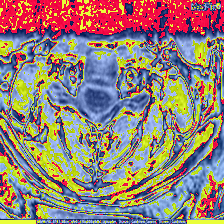

In [30]:
_img1

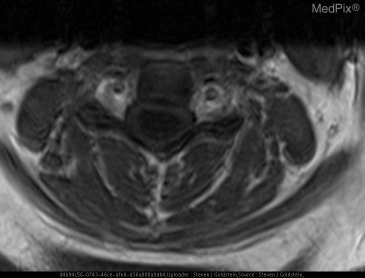

In [32]:
_img2.reduce(2)

In [33]:
_img1, _img2 = inspect_dataloader(valid_dataloader)

batchsize = 60
idx = tensor(25)
question: <s> what is most alarming about this mri </s> <pad> <pad>
question length: tensor(9)
answer: <s> quadriceps tendon rupture </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
type: mri
multilabel: ['quadriceps', 'rupture', 'tendon']


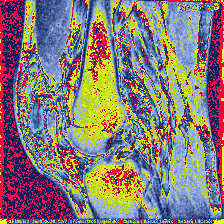

In [34]:
_img1

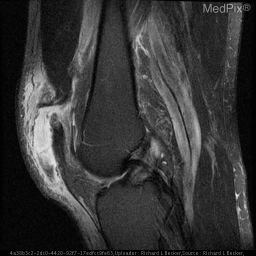

In [35]:
_img2.reduce(2)

In [36]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [37]:
oevqa_model = OpenEndedVQA(vocab_size=tokenizer.vocab_size,
                           start_idx=tokenizer.token2id[tokenizer.START_TOKEN],
                           embed_size=EMBEDDING_SIZE,
                           hidden_size=HIDDEN_SIZE,
                           question_vec_size=QUESTION_VEC_SIZE,
                           image_local_feat_size=IMAGE_LOCAL_FEAT_SIZE,
                           dropout_prob=DROPOUT_PROB,
                           n_type_classes=N_TYPE_CLASSES,
                           n_multilabel_classes=N_MULTILABEL_CLASSES)

In [38]:
oevqa_model = oevqa_model.to(DEVICE)

In [39]:
nlp_criterion = nn.CrossEntropyLoss(ignore_index=0) # ignore padding in loss
aux_criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(oevqa_model.parameters(), lr=LR)

In [40]:
scheduler = ReduceLROnPlateau(optimizer, factor=LR_DECAY, patience=DECAY_PATIENCE, mode='max', verbose=True)

In [41]:
!nvidia-smi

Tue Jun 15 01:03:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    On   | 00000000:17:00.0 Off |                  N/A |
|  0%   37C    P8    24W / 420W |      1MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:65:00.0 Off |                  N/A |
| 32%   

In [42]:
def compute_nlp_metrics(gt_sentences, pred_sentences, smoothing_function):
    assert gt_sentences.shape == pred_sentences.shape
    total_bleu = 0
    exact_matches = 0
    count = 0
    n = gt_sentences.shape[0]
    for i in range(n):
        reference = tokenizer.clean_sentence(gt_sentences[i])
        hypothesis = tokenizer.clean_sentence(pred_sentences[i])
        if len(reference) == 0:
            continue
        bleu = 0 if len(hypothesis) == 0 else sentence_bleu((reference,), hypothesis,
                                                            smoothing_function=smoothing_function, auto_reweigh=True)
        count += 1
        total_bleu += bleu
        if bleu == 1:
            exact_matches += 1        

    return total_bleu, exact_matches, count

In [43]:
def train_model(model, optimizer, nlp_criterion, aux_criterion, scheduler, dataloaders, epochs, checkpoint=None):
    
    since = time.time()
    # smoothing_function = SmoothingFunction().method1  
    smoothing_function = None

    if checkpoint:
        print('resuming training ....')
        history = checkpoint['history']
        epoch_one = 1 + len(history['train_loss'])
        epochs += len(history['train_loss'])
        best_wts = checkpoint['best_wts']
        best_dev_exact_matches = checkpoint['best_dev_exact_matches']
        best_train_exact_matches = checkpoint['best_train_exact_matches']
        model.load_state_dict(checkpoint['last_wts'])
    else:
        print('training from scratch ....')
        epoch_one = 1
        best_wts = copy.deepcopy(model.state_dict())
        best_dev_exact_matches = -1e9
        best_train_exact_matches = -1e9
        history = dict()
        for met in ('loss', 'bleu', 'exact_matches'):
            for phase in ('train', 'dev'):
                history['%s_%s' % (phase,met)] = []

    last_train_epoch_score = 0
    last_dev_epoch_score = 0

    for epoch in range(epoch_one, epochs+1):
        print('\n====== [Epoch {}/{}]'.format(epoch, epochs))

        for phase in ('train', 'dev'):

            print('--------------------- %s ---------------------' % phase)

            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_correct_type = 0
            running_correct_multilabel = 0
            running_exact_matches = 0
            running_bleu = 0
            running_quest_exact_matches = 0
            running_quest_bleu = 0
            running_count = 0
            running_answer_count = 0
            epoch_since = time.time()
            dataloader = dataloaders[phase]

            with torch.set_grad_enabled(phase == 'train'):

                for batch_idx, batch_dict in enumerate(dataloader):

                    images = batch_dict['i'].to(DEVICE)
                    questions = batch_dict['q'].to(DEVICE)
                    question_lengths = batch_dict['ql']
                    answers = batch_dict['a'].to(DEVICE)
                    types = batch_dict['t'].to(DEVICE)
                    multilabels = batch_dict['ml'].to(DEVICE)
                    batch_size = questions.size(0)

                    optimizer.zero_grad()

                    # forward pass
                    if phase == 'train':
                        output = model(images, questions, question_lengths, answers=answers, mode='train')
                    else:
                        output = model(images, questions, question_lengths, max_answer_length=answers.size(1), mode='eval')
                    
                    pred_answers, type_logits, multilabel_logits, pred_questions = output

                    answer_loss = nlp_criterion(pred_answers.view(-1, pred_answers.shape[-1]), answers.view(-1))
                    question_loss = nlp_criterion(pred_questions.view(-1, pred_questions.shape[-1]), questions.view(-1))
                    type_loss = aux_criterion(type_logits, types)
                    multilabel_loss = aux_criterion(multilabel_logits.view(-1, 3), multilabels.view(-1))
                    
                    final_loss = answer_loss + question_loss + type_loss + multilabel_loss
                    
                    correct_type = (type_logits.argmax(-1) == types).sum().item()
                    correct_multilabel = (multilabel_logits.view(-1, 3).argmax(-1) == multilabels.view(-1)).sum().item()

                    total_bleu, exact_matches, acount = compute_nlp_metrics(answers.cpu().numpy(), pred_answers.argmax(-1).cpu().numpy(), smoothing_function)
                    quest_bleu, quest_exact_matches, _ = compute_nlp_metrics(questions.cpu().numpy(), pred_questions.argmax(-1).cpu().numpy(), smoothing_function)

                    # backward pass + optimization only if in training phase
                    if phase == 'train':
                        final_loss.backward()
                        # clip_grad_norm_(model.parameters(), GRADIENT_CLIPPING)
                        optimizer.step()

                    # statistics
                    running_loss += final_loss.item() * batch_size
                    
                    running_correct_type += correct_type
                    running_correct_multilabel += correct_multilabel
                    
                    running_answer_count += acount
                    running_exact_matches += exact_matches
                    running_bleu += total_bleu
                    
                    running_quest_exact_matches += quest_exact_matches
                    running_quest_bleu += quest_bleu
                    
                    running_count += batch_size

                    if (batch_idx % 20 == 0 or batch_idx + 1 == len(dataloader)):
                        elapsed_time = time.time() - epoch_since
                        print("Batch: %d/%d, running_loss=%.5f, type_acc=%.5f, ml_acc=%.5f, bleu=%.5f, exact=%.5f, qbleu=%.5f, qexact=%.5f, elapsed_time=%.0fm %.0fs" % (
                            batch_idx+1, len(dataloader),
                            running_loss/running_count,
                            running_correct_type/running_count,
                            running_correct_multilabel/(running_count * N_MULTILABEL_CLASSES),
                            running_bleu/running_answer_count,
                            running_exact_matches/running_answer_count,
                            running_quest_bleu/running_count,
                            running_quest_exact_matches/running_count,
                            elapsed_time // 60, elapsed_time % 60,
                        ), end="\r")
                        # ))
            print()

            epoch_loss = running_loss / running_count
            epoch_bleu = running_bleu / running_answer_count
            epoch_exact_matches = running_exact_matches / running_answer_count
            epoch_quest_bleu = running_quest_bleu / running_count
            epoch_quest_exact_matches = running_quest_exact_matches / running_count
            epoch_type_acc = running_correct_type / running_count
            epoch_multilabel_acc = running_correct_multilabel / (running_count * N_MULTILABEL_CLASSES)

            epoch_score = epoch_bleu + epoch_quest_bleu + epoch_type_acc + epoch_multilabel_acc
            if phase == 'train':
                last_train_epoch_score = epoch_score
            else:
                last_dev_epoch_score = epoch_score

            history['%s_loss' % phase].append(epoch_loss)
            history['%s_bleu' % phase].append(epoch_bleu)
            history['%s_exact_matches' % phase].append(epoch_exact_matches)

            if phase == 'dev':
                scheduler.step(last_train_epoch_score * 0.8 + last_dev_epoch_score * 0.2) # decay learning rate if necessary
                if epoch_exact_matches > best_dev_exact_matches or (
                      epoch_exact_matches == best_dev_exact_matches and\
                      last_train_exact_matches > best_train_exact_matches): # improvement detected!
                    # update best dev and train exact_matches
                    best_dev_exact_matches = epoch_exact_matches
                    best_train_exact_matches = last_train_exact_matches
                    # update best weights
                    best_wts = copy.deepcopy(model.state_dict())
                    print('\t*** improvement detected! best_dev_exact_matches=%f' % best_dev_exact_matches)
            else:
                last_train_exact_matches = epoch_exact_matches

    print()
    elapsed_time = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
      elapsed_time // 60, elapsed_time % 60))
    print('Best dev exact_matches: {:4f}'.format(best_dev_exact_matches))

    return dict(
        best_wts=best_wts,
        last_wts=copy.deepcopy(model.state_dict()),
        history=history,
        best_dev_exact_matches=best_dev_exact_matches,
        best_train_exact_matches=best_train_exact_matches,
    )

In [44]:
ret = None
# ret = torch.load('./imageclef_vqa_model.checkpoint')

In [50]:
ret = train_model(oevqa_model, optimizer, nlp_criterion, aux_criterion, scheduler, dataloaders, epochs=20, checkpoint=ret)

resuming training ....

====== [Epoch 91/110]
--------------------- train ---------------------
Batch: 145/145, running_loss=0.02058, type_acc=1.00000, ml_acc=0.93780, bleu=0.99669, exact=0.99597, qbleu=1.00000, qexact=1.00000, elapsed_time=1m 52s
--------------------- dev ---------------------
Batch: 9/9, running_loss=12.70687, type_acc=1.00000, ml_acc=0.97502, bleu=0.19249, exact=0.18800, qbleu=1.00000, qexact=1.00000, elapsed_time=0m 5s

====== [Epoch 92/110]
--------------------- train ---------------------
Batch: 145/145, running_loss=0.01839, type_acc=0.99977, ml_acc=0.93785, bleu=0.99807, exact=0.99768, qbleu=1.00000, qexact=1.00000, elapsed_time=1m 51s
--------------------- dev ---------------------
Batch: 9/9, running_loss=12.64808, type_acc=1.00000, ml_acc=0.97507, bleu=0.19455, exact=0.19000, qbleu=1.00000, qexact=1.00000, elapsed_time=0m 5s

====== [Epoch 93/110]
--------------------- train ---------------------
Batch: 145/145, running_loss=0.01550, type_acc=0.99988, ml_acc

Batch: 145/145, running_loss=0.01042, type_acc=0.99988, ml_acc=0.93817, bleu=0.99915, exact=0.99915, qbleu=1.00000, qexact=1.00000, elapsed_time=1m 51s
--------------------- dev ---------------------
Batch: 9/9, running_loss=13.01137, type_acc=1.00000, ml_acc=0.97564, bleu=0.19505, exact=0.19200, qbleu=1.00000, qexact=1.00000, elapsed_time=0m 5s
Epoch   110: reducing learning rate of group 0 to 1.1130e-04.

Training complete in 38m 50s
Best dev exact_matches: 0.210000


In [51]:
torch.save(ret, './imageclef_vqa_model_v5(test_type+labels_in_train).checkpoint')

In [47]:
def plot_train_dev_curves(history, figsize=(12, 6)):
    epochs = list(range(1, len(history['train_loss'])+1))
    
    plt.figure(figsize=figsize)
    eps = 0.9
    
    ax = plt.subplot(121)
    ax.set_xlim(epochs[0]-eps, epochs[-1]+eps)
    ax.set_title('Loss per epoch')
    ax.plot(epochs, history['train_loss'], label='train_loss')
    ax.plot(epochs, history['dev_loss'], label='dev_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')    
    ax.legend()
    
    ax = plt.subplot(122)
    ax.set_xlim(epochs[0]-eps, epochs[-1]+eps)
    ax.set_title('Bleu per epoch')
    ax.plot(epochs, history['train_bleu'], label='train_bleu')
    ax.plot(epochs, history['dev_bleu'], label='dev_bleu')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Bleu')    
    best_dev_bleu, best_dev_i = max((a,i) for i,a in enumerate(history['dev_bleu']))
    ax.hlines(best_dev_bleu, epochs[0], epochs[-1], colors=('red',), linestyles='dashed',
               label='best_dev_bleu=%.3f, epoch=%d' % (best_dev_bleu, best_dev_i))
    best_train_bleu, best_train_i = max((a,i) for i,a in enumerate(history['train_bleu']))
    ax.hlines(best_train_bleu, epochs[0], epochs[-1], colors=('green',), linestyles='dashed',
               label='best_train_bleu=%.3f, epoch=%d' % (best_train_bleu, best_train_i))    
    ax.legend()
    
    plt.show()

In [48]:
import IPython
shell = IPython.get_ipython()
shell.enable_matplotlib(gui='inline')

('inline', 'module://ipykernel.pylab.backend_inline')

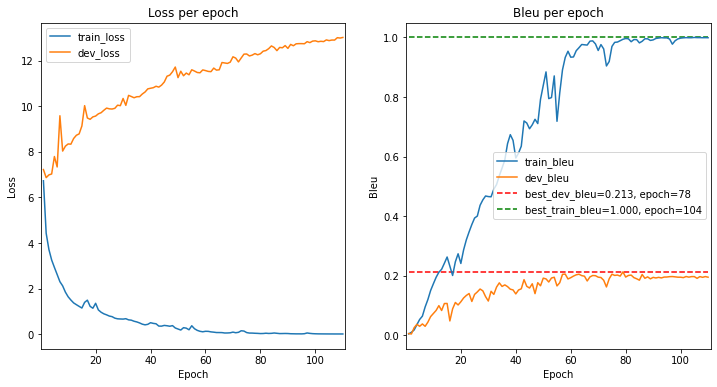

In [52]:
plot_train_dev_curves(ret['history'])

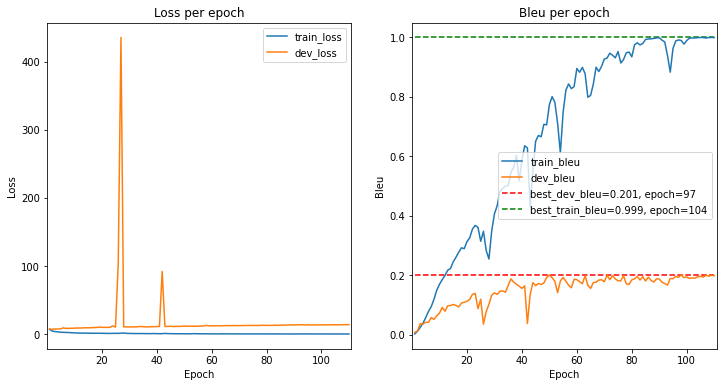

In [100]:
plot_train_dev_curves(ret['history'])

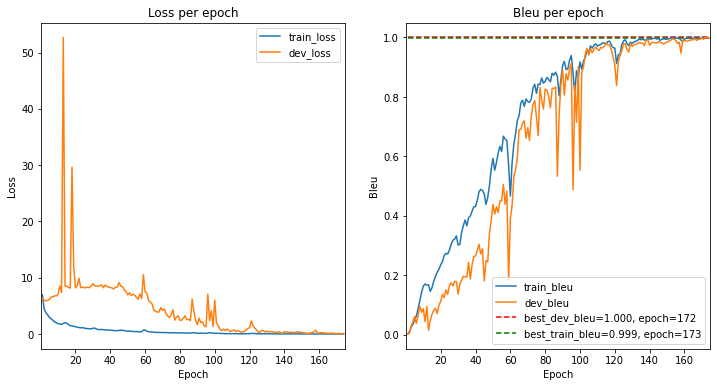

In [87]:
plot_train_dev_curves(ret['history'])

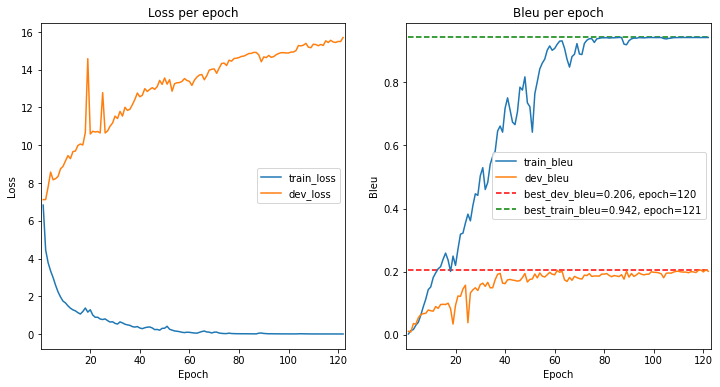

In [48]:
plot_train_dev_curves(ret['history'])

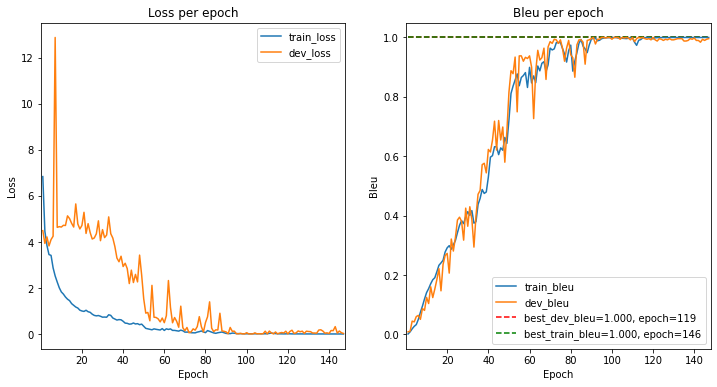

In [47]:
plot_train_dev_curves(ret['history'])

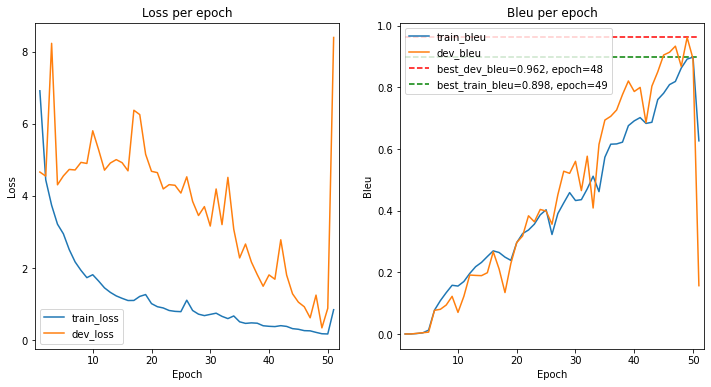

In [156]:
plot_train_dev_curves(ret['history'])

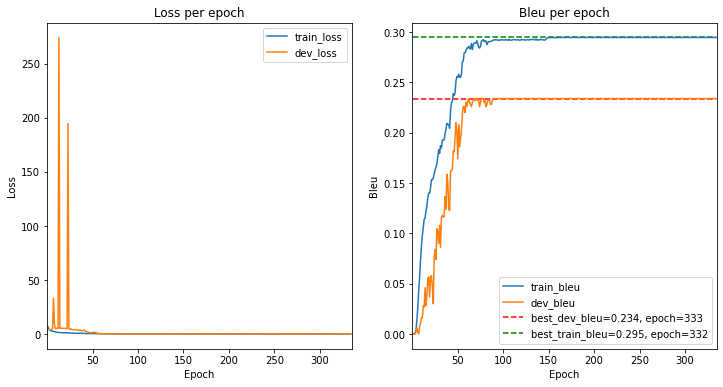

In [61]:
plot_train_dev_curves(ret['history'])

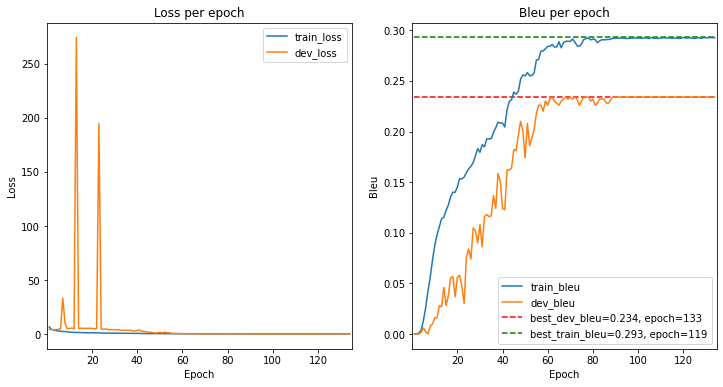

In [48]:
plot_train_dev_curves(ret['history'])

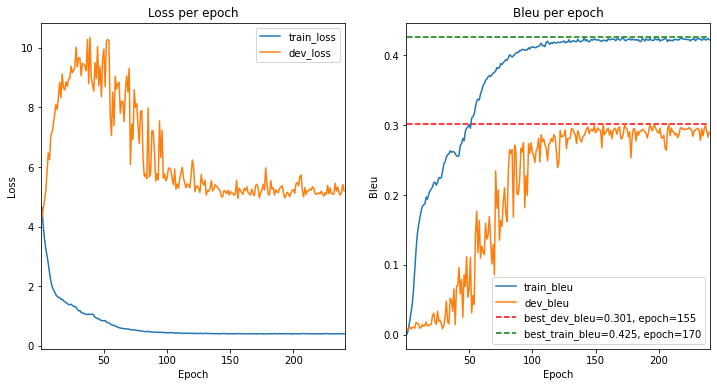

In [35]:
plot_train_dev_curves(ret['history'])

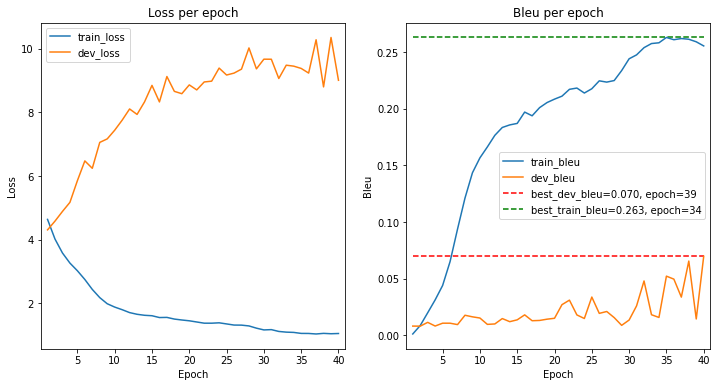

In [33]:
plot_train_dev_curves(ret['history'])

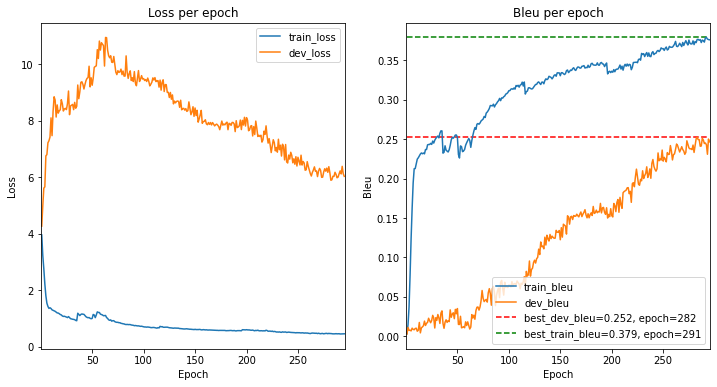

In [144]:
plot_train_dev_curves(ret['history'])

In [54]:
def append_test_results(
    dataset,
    
    image_path_list,
    question_list,
    answer_list,
    type_list,
    labels_list,
    
    pred_question_list,
    pred_answer_list,
    pred_type_list,    
    pred_labels_list,
    
    bleu_score_list,
    
    indexes,
    pred_questions,
    pred_answers,
    pred_types,
    pred_labels,
    
    smoothing_function,
):
    batchsize = pred_questions.shape[0]
    
    for i in range(batchsize):
        idx = indexes[i]
        image_path_list.append(dataset.images[idx])
        
        question_list.append(tokenizer.ids2sentence(tokenizer.clean_sentence(dataset.questions[idx])))
        answer_list.append(tokenizer.ids2sentence(tokenizer.clean_sentence(dataset.answers[idx])))
        type_list.append(imagetype2name[dataset.types[idx]])
        labels_list.append(get_labels(dataset.labels[idx]))
        
        pred_question_list.append(tokenizer.ids2sentence(tokenizer.clean_sentence(pred_questions[i])))
        pred_answer_list.append(tokenizer.ids2sentence(tokenizer.clean_sentence(pred_answers[i])))
        pred_type_list.append(imagetype2name[pred_types[i]])
        pred_labels_list.append(get_labels(pred_labels[i]))
        
        bleu = sentence_bleu((answer_list[-1].split(),), pred_answer_list[-1].split(), smoothing_function=smoothing_function, auto_reweigh=True)
        bleu_score_list.append(bleu)
    

def test_model_with_details(model, weights, dataset, dataloader, tokenizer):
    
    since = time.time()
    # smoothing_function = SmoothingFunction().method1  
    smoothing_function = None
    
    old_weights = copy.deepcopy(model.state_dict())
    model.load_state_dict(weights)
    model.eval()
            
    running_loss = 0.0
    running_correct_type = 0
    running_correct_multilabel = 0
    running_exact_matches = 0
    running_bleu = 0
    running_quest_exact_matches = 0
    running_quest_bleu = 0
    running_count = 0
    
    image_path_list = []
    question_list = []
    answer_list = []
    type_list = []
    labels_list = []    
    pred_question_list = []
    pred_answer_list = []
    pred_type_list = []
    pred_labels_list = []
    bleu_score_list = []

    with torch.set_grad_enabled(False):

        for batch_idx, batch_dict in enumerate(dataloader):

            indexes = batch_dict['idx'].to(DEVICE)
            images = batch_dict['i'].to(DEVICE)
            questions = batch_dict['q'].to(DEVICE)
            question_lengths = batch_dict['ql']
            answers = batch_dict['a'].to(DEVICE)
            types = batch_dict['t'].to(DEVICE)
            multilabels = batch_dict['ml'].to(DEVICE)
            batch_size = questions.size(0)

            output = model(images, questions, question_lengths, max_answer_length=answers.size(1), mode='eval')

            answer_logits, type_logits, multilabel_logits, question_logits = output

            answer_loss = nlp_criterion(answer_logits.view(-1, answer_logits.shape[-1]), answers.view(-1))
            question_loss = nlp_criterion(question_logits.view(-1, question_logits.shape[-1]), questions.view(-1))
            type_loss = aux_criterion(type_logits, types)
            multilabel_loss = aux_criterion(multilabel_logits.view(-1, 3), multilabels.view(-1))

            final_loss = answer_loss + question_loss + type_loss + multilabel_loss
            
            pred_types = type_logits.argmax(-1)
            pred_multilabels = multilabel_logits.view(-1, 3).argmax(-1)
            pred_answers = answer_logits.argmax(-1).cpu().numpy()
            pred_questions = question_logits.argmax(-1).cpu().numpy()
            
            answers_cpu = answers.cpu().numpy()
            questions_cpu = questions.cpu().numpy()

            correct_type = (pred_types == types).sum().item()
            correct_multilabel = (pred_multilabels == multilabels.view(-1)).sum().item()
            total_bleu, exact_matches, _ = compute_nlp_metrics(answers_cpu, pred_answers, smoothing_function)
            quest_bleu, quest_exact_matches, _ = compute_nlp_metrics(questions_cpu, pred_questions, smoothing_function)
            
            append_test_results(
                dataset,
                image_path_list,
                question_list,
                answer_list,
                type_list,
                labels_list,
                pred_question_list,
                pred_answer_list,
                pred_type_list,
                pred_labels_list,
                bleu_score_list,
                indexes,
                pred_questions,
                pred_answers,
                pred_types,
                pred_multilabels.view(-1, N_MULTILABEL_CLASSES),
                smoothing_function,
            )

            # statistics
            running_loss += final_loss.item() * batch_size

            running_correct_type += correct_type
            running_correct_multilabel += correct_multilabel

            running_exact_matches += exact_matches
            running_bleu += total_bleu

            running_quest_exact_matches += quest_exact_matches
            running_quest_bleu += quest_bleu

            running_count += batch_size

            if (batch_idx % 20 == 0 or batch_idx + 1 == len(dataloader)):
                elapsed_time = time.time() - since
                print("Batch: %d/%d, running_loss=%.5f, type_acc=%.5f, ml_acc=%.5f, bleu=%.5f, exact=%.5f, qbleu=%.5f, qexact=%.5f, elapsed_time=%.0fm %.0fs" % (
                    batch_idx+1, len(dataloader),
                    running_loss/running_count,
                    running_correct_type/running_count,
                    running_correct_multilabel/(running_count * N_MULTILABEL_CLASSES),
                    running_bleu/running_count,
                    running_exact_matches/running_count,
                    running_quest_bleu/running_count,
                    running_quest_exact_matches/running_count,
                    elapsed_time // 60, elapsed_time % 60,
                ), end="\r")
                # ))
    print()

    avg_loss = running_loss / running_count
    avg_bleu = running_bleu / running_count
    avg_exact_matches = running_exact_matches / running_count
    avg_quest_bleu = running_quest_bleu / running_count
    avg_quest_exact_matches = running_quest_exact_matches / running_count
    avg_type_acc = running_correct_type / running_count
    avg_multilabel_acc = running_correct_multilabel / (running_count * N_MULTILABEL_CLASSES)
    
    model.load_state_dict(old_weights)

    elapsed_time = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(
      elapsed_time // 60, elapsed_time % 60))
    print('avg_loss =', avg_loss)
    print('avg_bleu =', avg_bleu)
    print('avg_exact_matches =', avg_exact_matches)
    print('avg_quest_bleu =', avg_quest_bleu)
    print('avg_quest_exact_matches =', avg_quest_exact_matches)
    print('avg_type_acc =', avg_type_acc)
    print('avg_multilabel_acc =', avg_multilabel_acc)

    return dict(
        image_path_list = image_path_list,
        question_list = question_list,
        answer_list = answer_list,
        type_list = type_list,
        labels_list = labels_list,
        pred_question_list = pred_question_list,
        pred_answer_list = pred_answer_list,
        pred_type_list = pred_type_list,
        pred_labels_list = pred_labels_list,
        bleu_score_list = bleu_score_list,
    )

In [55]:
val_results = test_model_with_details(oevqa_model, ret['best_wts'], valid_dataset, valid_dataloader, tokenizer)

Batch: 9/9, running_loss=12.25238, type_acc=1.00000, ml_acc=0.97448, bleu=0.21289, exact=0.21000, qbleu=1.00000, qexact=1.00000, elapsed_time=0m 11s
Testing complete in 0m 11s
avg_loss = 12.25238052368164
avg_bleu = 0.21288921739077876
avg_exact_matches = 0.21
avg_quest_bleu = 1.0
avg_quest_exact_matches = 1.0
avg_type_acc = 1.0
avg_multilabel_acc = 0.9744757281553398


In [56]:
def show_example(results, i):
    print('answer:', results['answer_list'][i])
    print('pred_answer:', results['pred_answer_list'][i])
    print('bleu score:', results['bleu_score_list'][i])
    print()
    print('question:', results['question_list'][i])
    print('pred_question:', results['pred_question_list'][i])
    print()    
    print('type:', results['type_list'][i])
    print('pred_type:', results['pred_type_list'][i])
    print()
    print('labels:', results['labels_list'][i])
    print('pred_labels:', results['pred_labels_list'][i])
    return Image.open(results['image_path_list'][i]).reduce(3)

answer: supracondylar fracture
pred_answer: nonossifying fibroma
bleu score: 0

question: what is the primary abnormality in this image
pred_question: what is the primary abnormality in this image

type: x-ray
pred_type: x-ray

labels: ['fracture', 'supracondylar']
pred_labels: ['supracondylar']


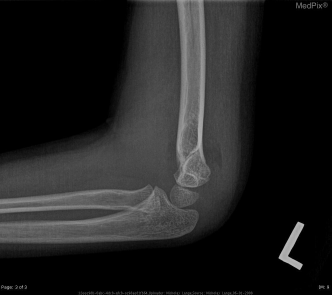

In [64]:
show_example(val_results, 6)

answer: partial anomalous pulmonary venous return
pred_answer: partial anomalous pulmonary venous return
bleu score: 1.0

question: what abnormality is seen in the image
pred_question: what abnormality is seen in the image

type: ct scan
pred_type: ct scan

labels: ['anomalous', 'partial', 'pulmonary', 'return', 'venous']
pred_labels: ['anomalous', 'partial', 'pulmonary', 'return', 'venous']


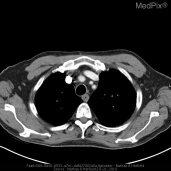

In [79]:
show_example(val_results, -10)

answer: supracondylar fracture
pred_answer: supracondylar fracture
bleu score: 1.0

question: what is the primary abnormality in this image
pred_question: what is the primary abnormality in this image

type: x-ray
pred_type: x-ray

labels: ['fracture', 'supracondylar']
pred_labels: ['fracture', 'supracondylar']


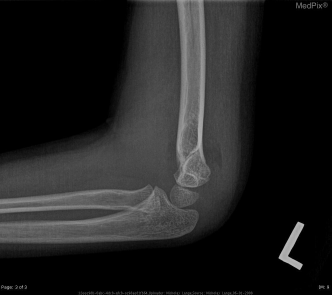

In [61]:
show_example(val_results, 6)

answer: acute appendicitis
pred_answer: acute appendicitis
bleu score: 1.0

question: what is the primary abnormality in this image
pred_question: what is the primary abnormality in this image

type: ct scan
pred_type: ct scan

labels: ['acute', 'appendicitis']
pred_labels: ['acute', 'appendicitis']


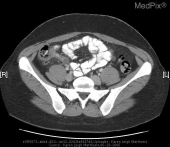

In [74]:
show_example(val_results, -105)

answer: rheumatoid arthritis
pred_answer: rheumatoid arthritis
bleu score: 1.0

question: what is the primary abnormality in this image
pred_question: what is the primary abnormality in this image

type: x-ray
pred_type: x-ray

labels: ['arthritis', 'rheumatoid']
pred_labels: ['arthritis', 'rheumatoid']


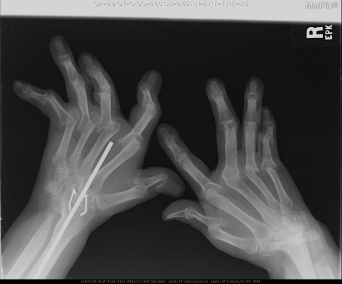

In [85]:
show_example(val_results, -100)

answer: cholelithiasis
pred_answer: cholelithiasis
bleu score: 1.0

question: what is abnormal in the ct scan
pred_question: what is abnormal in the ct scan

type: ct scan
pred_type: ct scan

labels: ['cholelithiasis']
pred_labels: ['cholelithiasis']


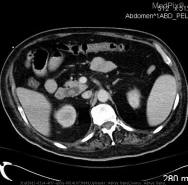

In [84]:
show_example(val_results, 25)

In [86]:
test_dataset = VQATestDataset(tokenizer)

In [87]:
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             collate_fn=collate_test_batch)

In [68]:
def test_model(model, weights, dataloader, tokenizer):    
    
    old_weights = copy.deepcopy(model.state_dict())
    model.load_state_dict(weights)
    model.eval()    
    id2output = dict()
              
    with torch.set_grad_enabled(False):              
        for batch_idx, batch_dict in tqdm(enumerate(dataloader)):
            idxs = batch_dict['idx']
            images = batch_dict['i'].to(DEVICE)
            questions = batch_dict['q'].to(DEVICE)
            question_lengths = batch_dict['ql']            
            
            output = model(images, questions, question_lengths, max_answer_length = 10, mode = 'eval')            
            answer_logits, type_logits, multilabel_logits, question_logits = output
            
            pred_types = type_logits.argmax(-1)
            pred_labels = multilabel_logits.view(-1, N_MULTILABEL_CLASSES, 3).argmax(-1)
            pred_answers = answer_logits.argmax(-1).cpu().numpy()
            pred_questions = question_logits.argmax(-1).cpu().numpy()
            
            for i in range(answer_logits.size(0)):
                _id = dataloader.dataset.ids[idxs[i]]
                id2output[_id] = {
                    'pred_answer': tokenizer.ids2sentence(tokenizer.clean_sentence(pred_answers[i])).split(),
                    'pred_question': tokenizer.ids2sentence(tokenizer.clean_sentence(pred_questions[i])),
                    'pred_type': imagetype2name[pred_types[i]],
                    'pred_labels': get_labels(pred_labels[i]),
                }
    
    model.load_state_dict(old_weights)
    
    return id2output

In [69]:
test_id2output = test_model(oevqa_model, ret['best_wts'], valid_dataloader, tokenizer)

8it [00:10,  1.35s/it]


In [71]:
with open('imageclef_2021_vqa_challenge__test_id2output.pickle', 'wb') as f:
    pickle.dump(test_id2output, f, protocol=pickle.HIGHEST_PROTOCOL)

In [72]:
with open("./imageclef_2021_vqa_challenge__submission.txt", "w") as f:
    for i, answer in enumerate(pred_answers):        
        f.write(f"{valid_dataset.image_ids[i]}|{answer}\n")

NameError: name 'pred_answers' is not defined